In [1]:
import numpy as np
import pandas as pd
import scanpy as sc



In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.5 scipy==1.7.3 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [3]:
results_file = 'C:\\Users\\Mujtaba Barci\\bioimformatic project\\pbmc3k.h5ad\\'

C:\\Users\\Mujtaba Barci\\Desktop\\Bioimformatics\\PBMC3K data\\New folder

C:\\Users\\Mujtaba Barci\\bioimformatic project\\Untitled Folder

In [4]:
adata = sc.read_10x_mtx(
    'C:\\Users\\Mujtaba Barci\\Desktop\\Bioimformatics\\PBMC3K data\\filtered_gene_bc_matrices\\hg19\\',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache\C-Users-Mujtaba Barci-Desktop-Bioimformatics-PBMC3K data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [5]:
adata.var_names_make_unique()

In [6]:
adata


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

<b> **Preprocessing:** </b>

normalizing counts per cell
    finished (0:00:00)


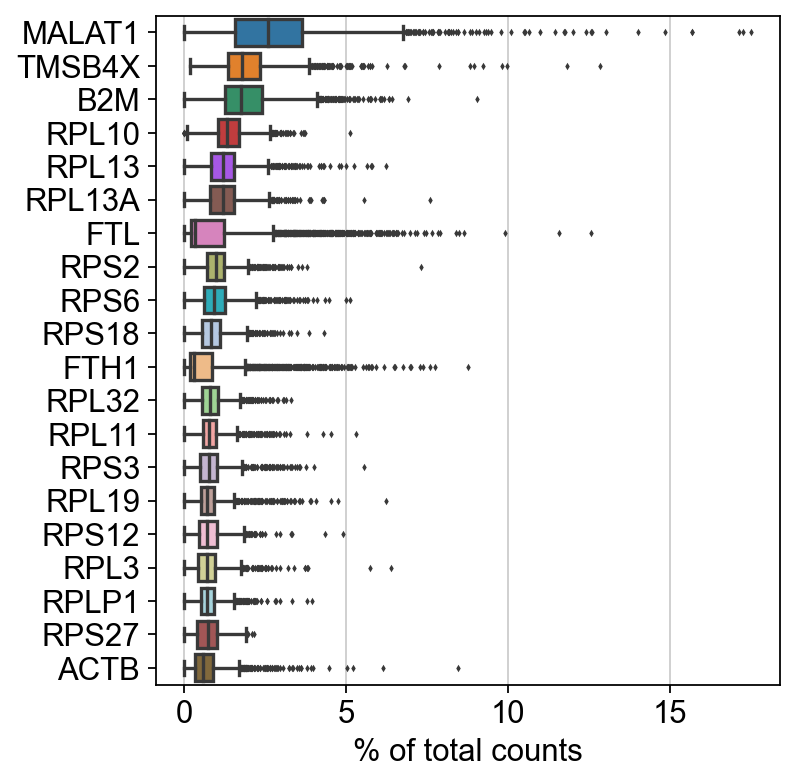

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20)

Filtering:

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [9]:
#mitochondrial genes filtering
adata.var['mt'] = adata.var_names.str.startswith ('MT-')
sc.pp.calculate_qc_metrics (adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True )

violin plot/cal:
     1.n_genes_by_counts
    2.total_counts
     3.pct_counts_mt


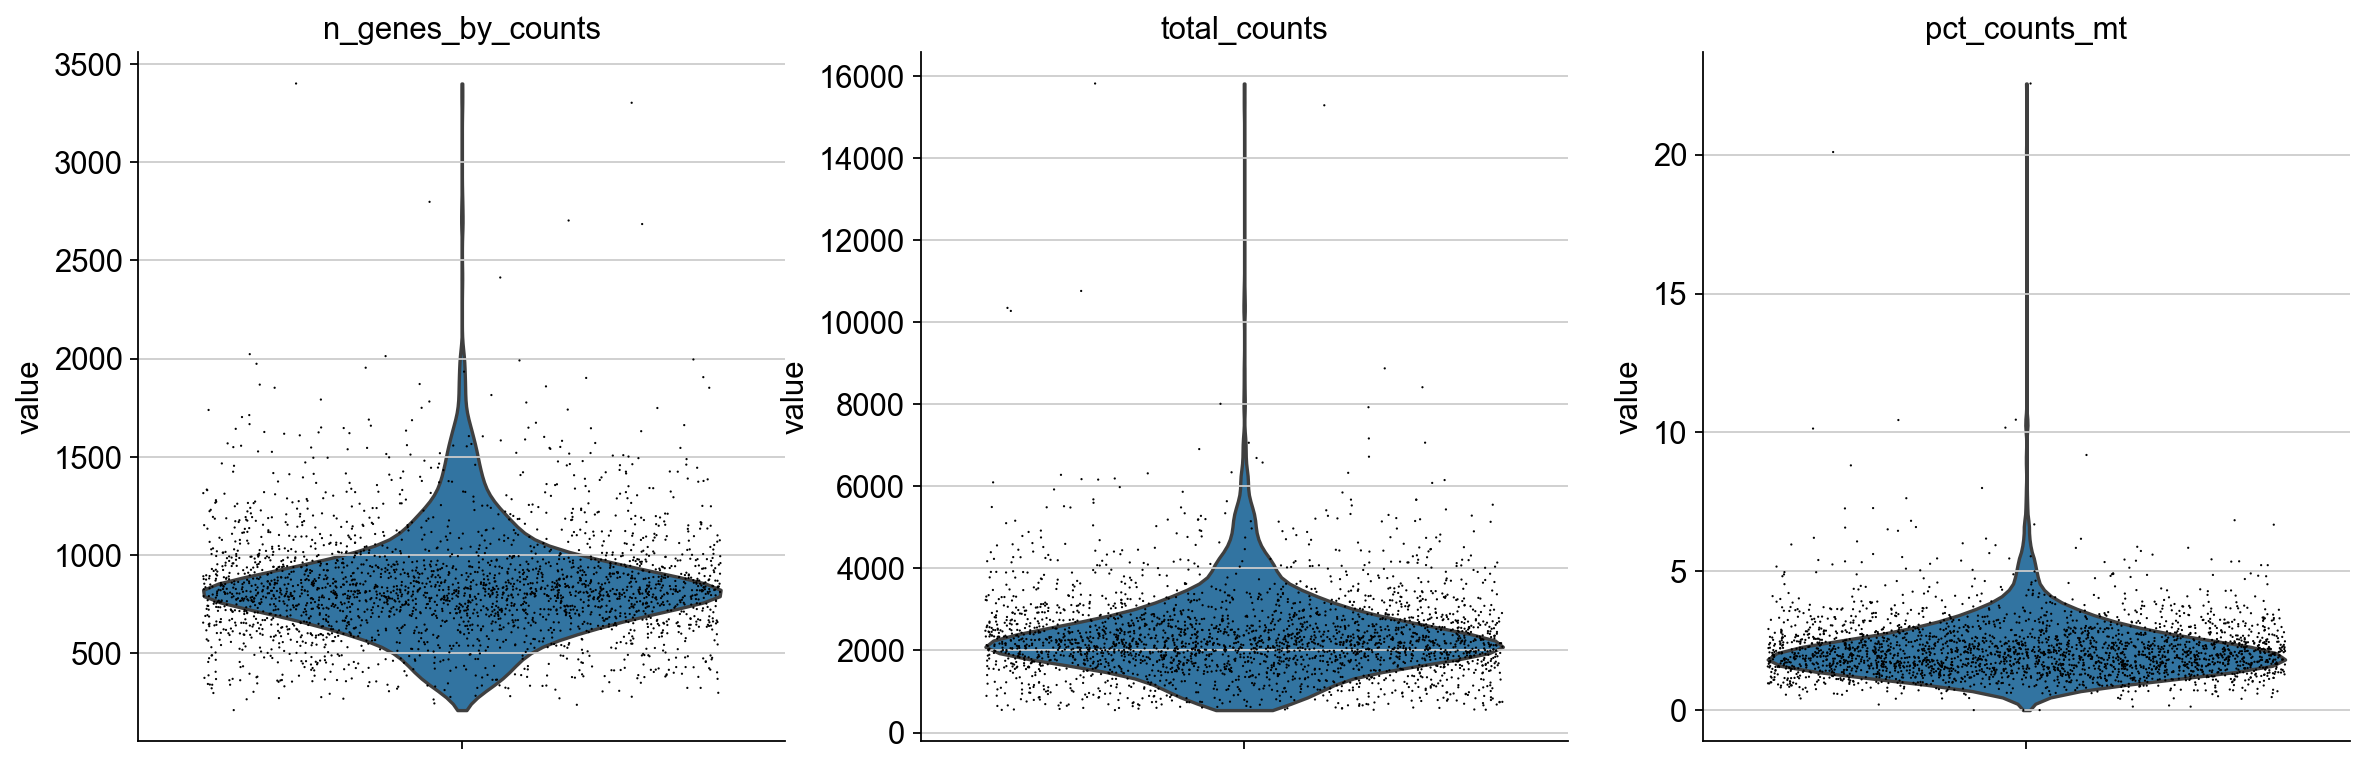

In [10]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts:



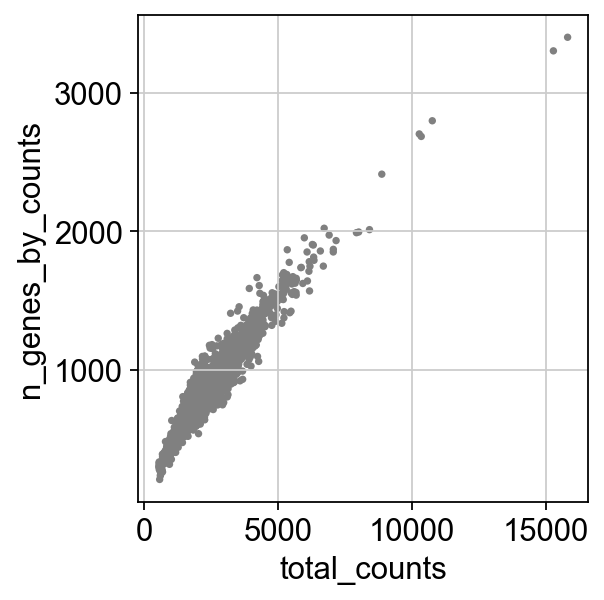

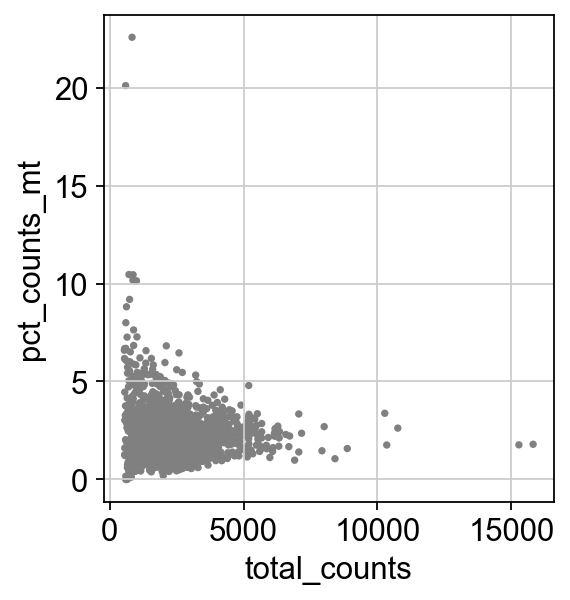

In [11]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')

slicing Annadata:


In [12]:
adata = adata[adata.obs.n_genes_by_counts <2500, :]
adata = adata[adata.obs.pct_counts_mt <5, :]

Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, and logarithmize the Data:

In [79]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\scanpy\preprocessing\_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


In [98]:
sc.pp.log1p(adata)

C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\scanpy\preprocessing\_simple.py:352: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


Highly variable gene:

In [15]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


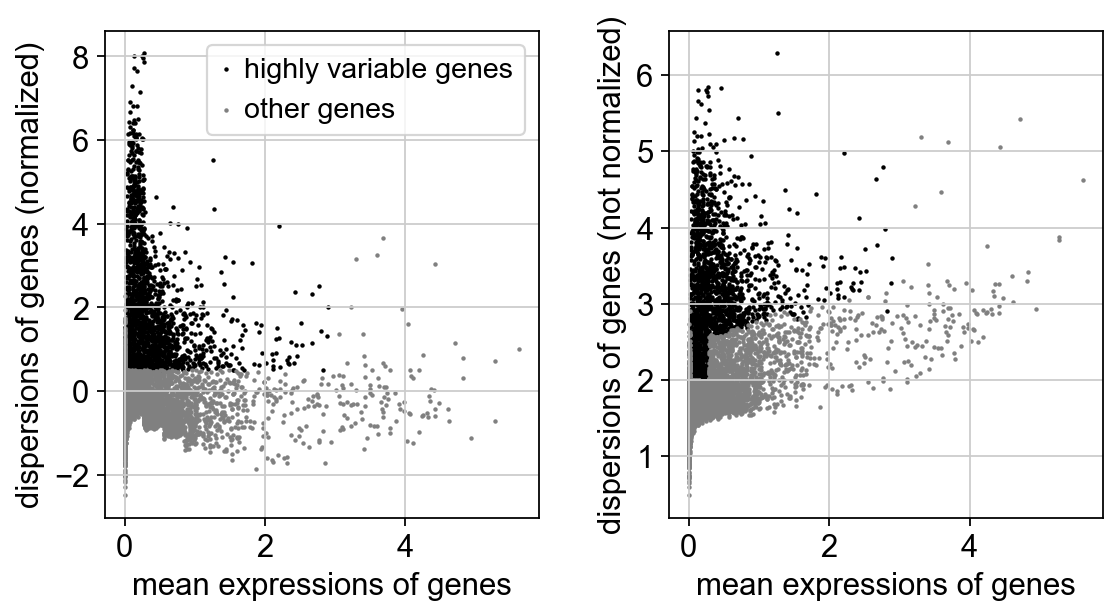

In [16]:
sc.pl.highly_variable_genes(adata)

In [17]:
adata.raw = adata  #.raw attribute of the AnnData object to the normalized and logarithmized raw gene expression

Filtering highly variable gene results:(unnecessary)

In [18]:
adata = adata[:, adata.var.highly_variable]


Regress_out unwanted source of Varitaion:

In [19]:
adata = adata[:, adata.var.highly_variable]

In [20]:
#Scale each gene to unit variance
sc.pp.scale(adata, max_value=10)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


### Principal component analysis:


In [21]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


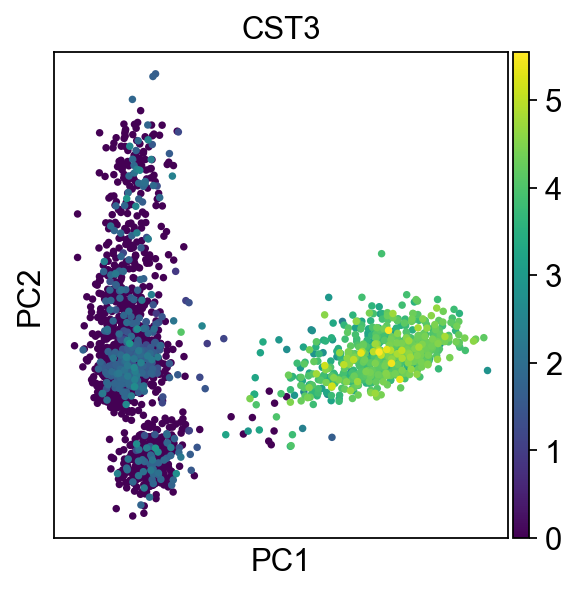

In [22]:
sc.pl.pca(adata, color='CST3')


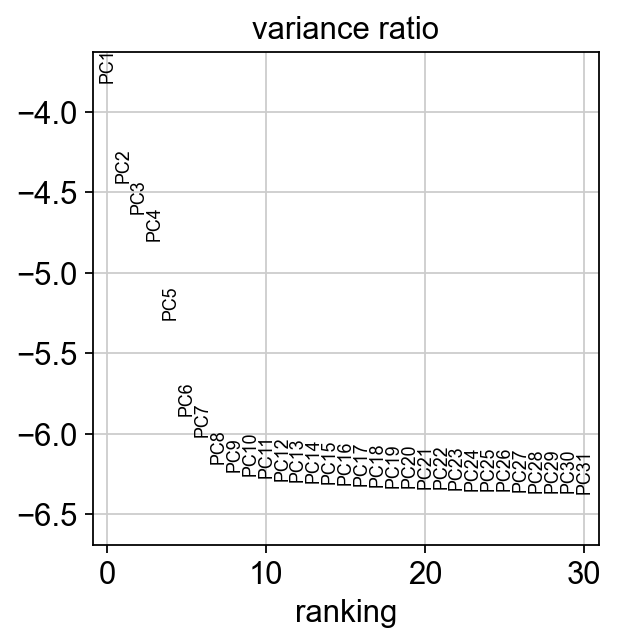

In [23]:
sc.pl.pca_variance_ratio(adata, log=True)

In [24]:
adata.write(results_file) #Save the result.

adata


AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

### Computing and Embedding the Neighborshood Graph:


In [25]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


In [26]:
sc.tl.umap(adata)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


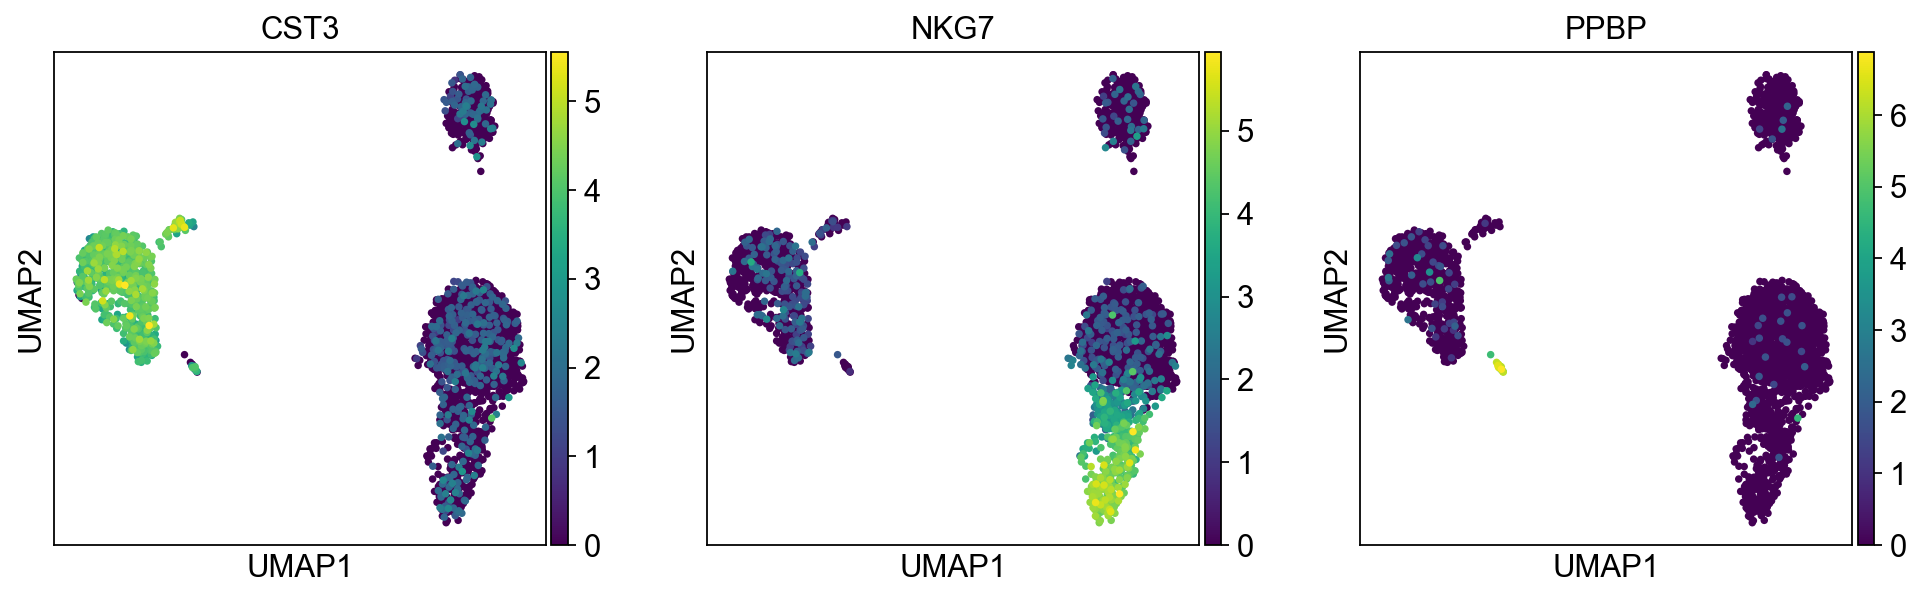

In [27]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])


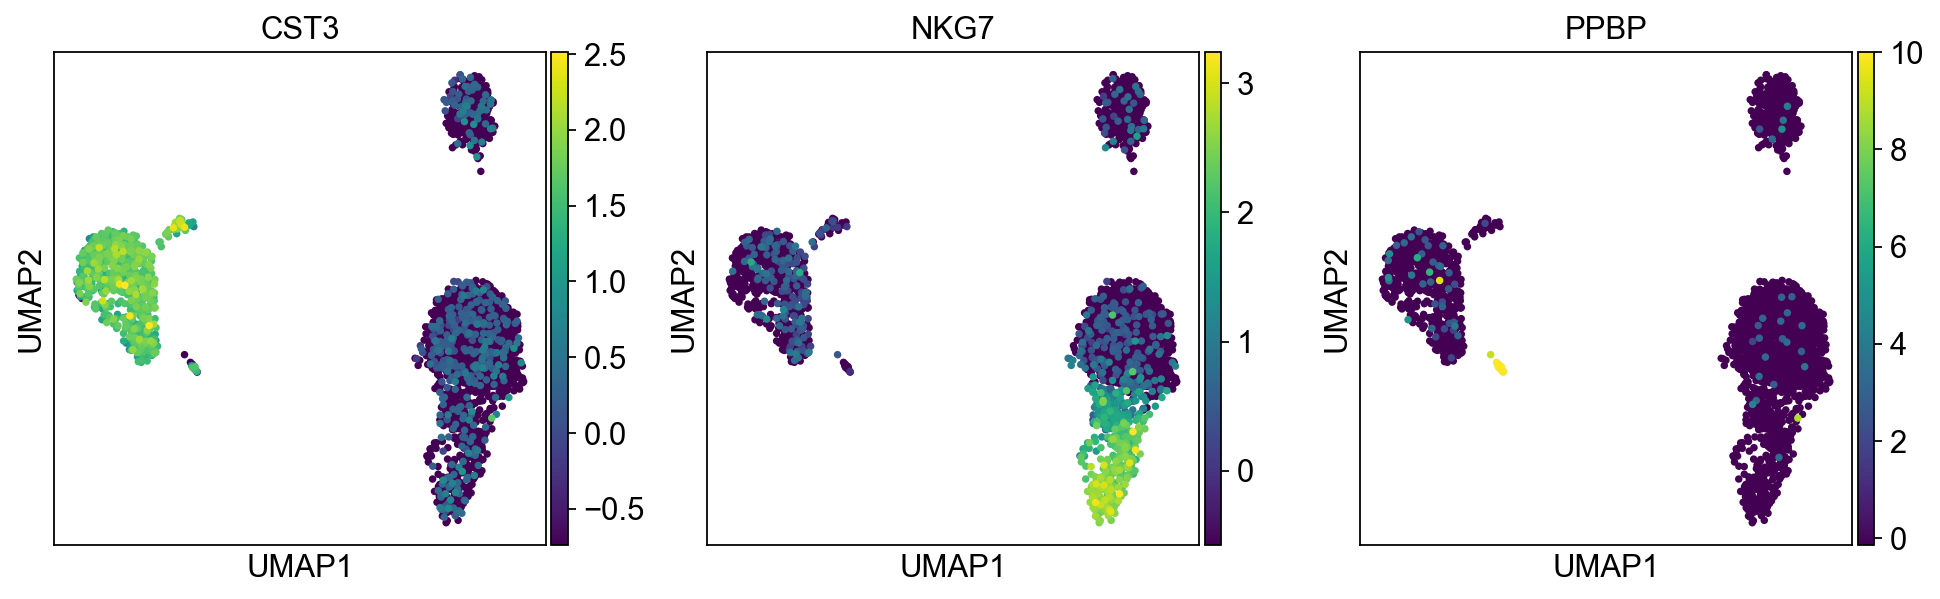

In [28]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)


### Clustering the neighborhood graph:


In [82]:
sc.tl.leiden(adata, resolution=0.85)

running Leiden clustering
    finished (0:00:00)


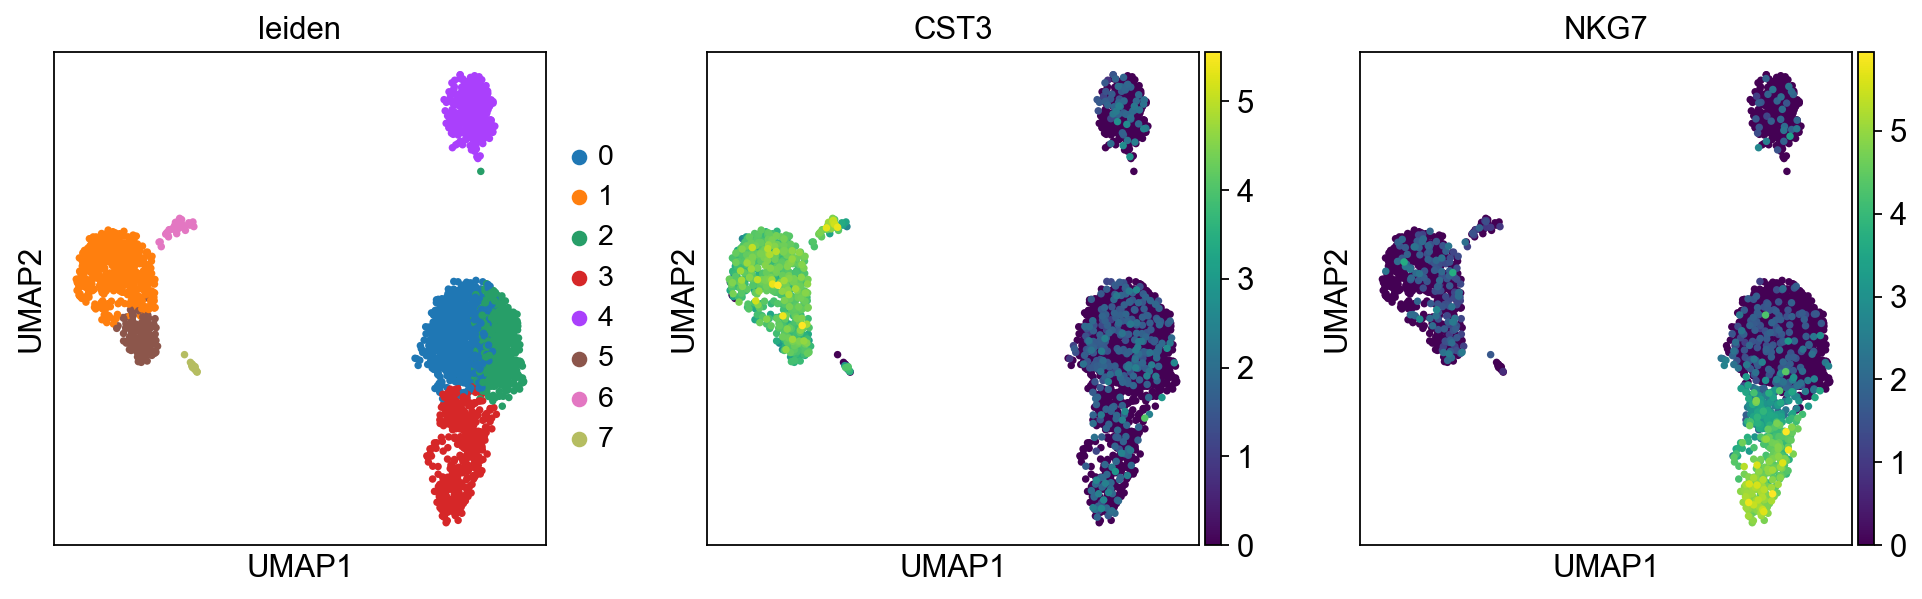

In [83]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

In [76]:
adata.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden
AAACATACAACCAC-1,781,779,2419.0,73.0,3.017776,0
AAACATTGAGCTAC-1,1352,1352,4903.0,186.0,3.793596,4
AAACATTGATCAGC-1,1131,1129,3147.0,28.0,0.889736,0
AAACCGTGCTTCCG-1,960,960,2639.0,46.0,1.743085,1
AAACCGTGTATGCG-1,522,521,980.0,12.0,1.224490,3
...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,1155,1153,3459.0,73.0,2.110436,1
TTTCTACTGAGGCA-1,1227,1224,3443.0,32.0,0.929422,4
TTTCTACTTCCTCG-1,622,622,1684.0,37.0,2.197150,4
TTTGCATGAGAGGC-1,454,452,1022.0,21.0,2.054795,4


In [84]:
adata.write(results_file)

### Finding marker genes:

In [85]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

ranking genes
    finished (0:00:00)


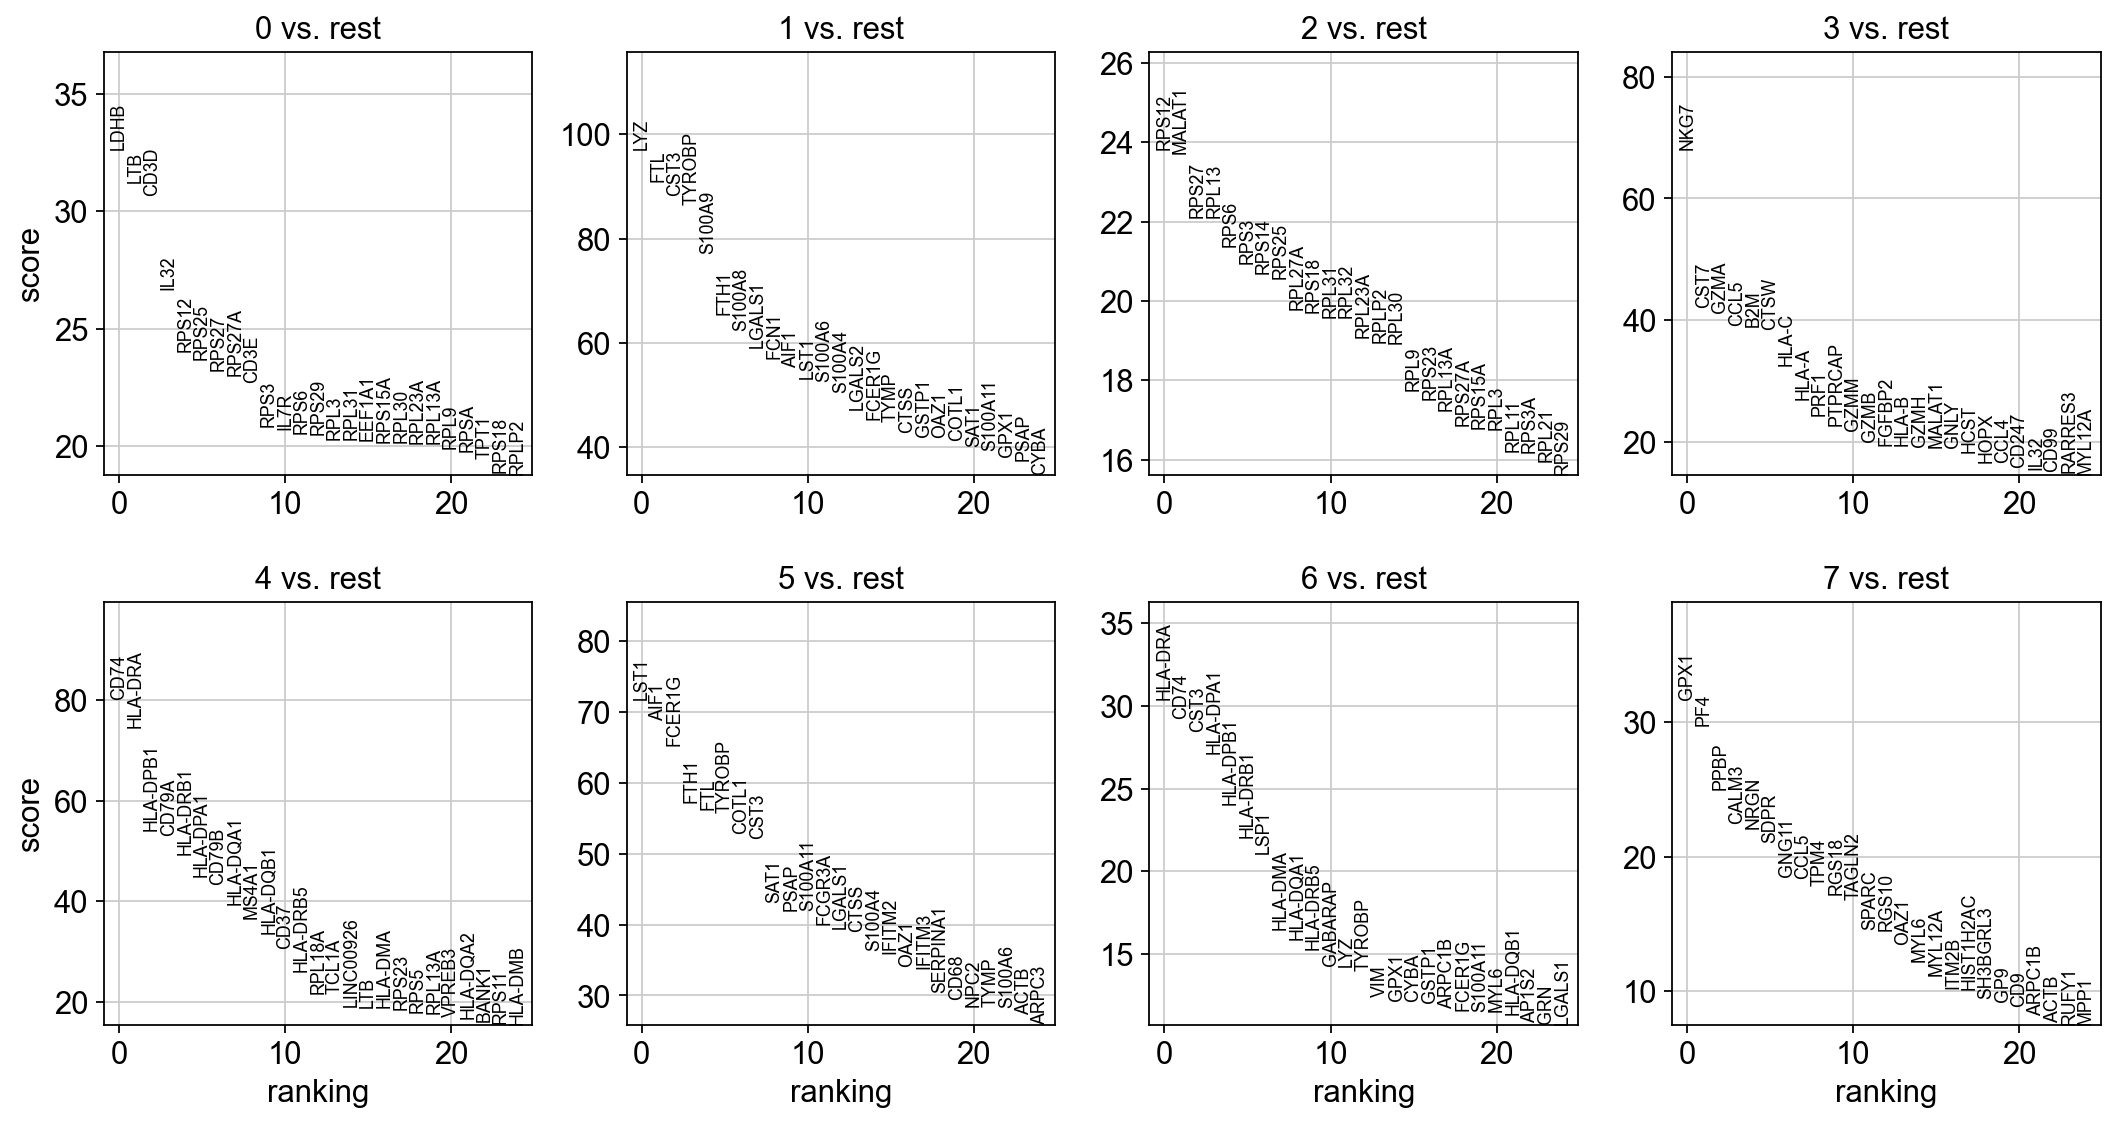

In [86]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [87]:
sc.settings.verbosity = 2  # reduce the verbosity


ranking genes
    finished (0:00:05)


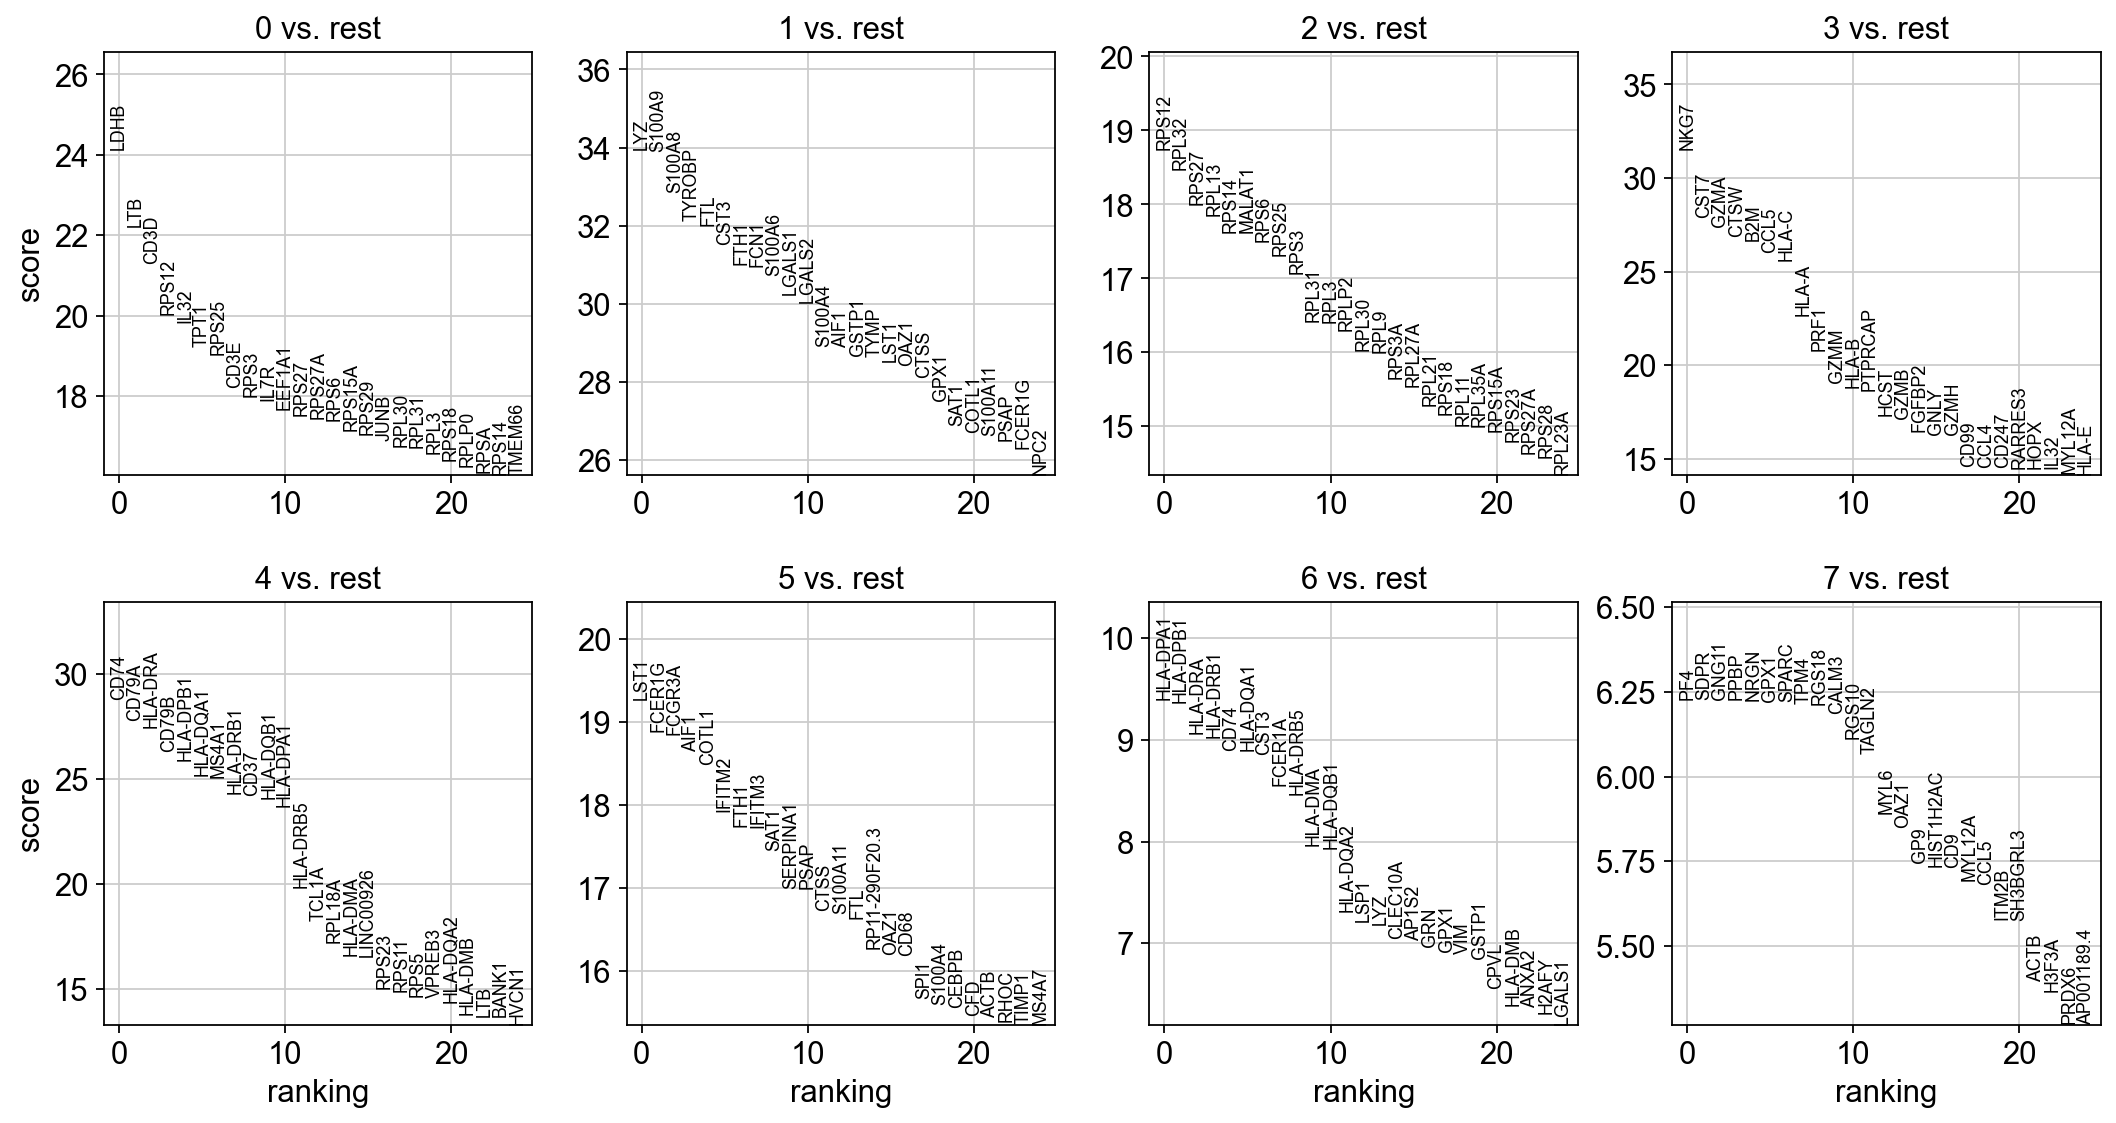

In [88]:
# using wilcoxon 
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [89]:
adata.uns['rank_genes_groups'] ['names'] ['0']

array(['LDHB', 'LTB', 'CD3D', ..., 'HLA-DRA', 'CYBA', 'CD74'],
      dtype=object)

In [90]:
adata.write(results_file)


ranking genes
    finished (0:00:07)


C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


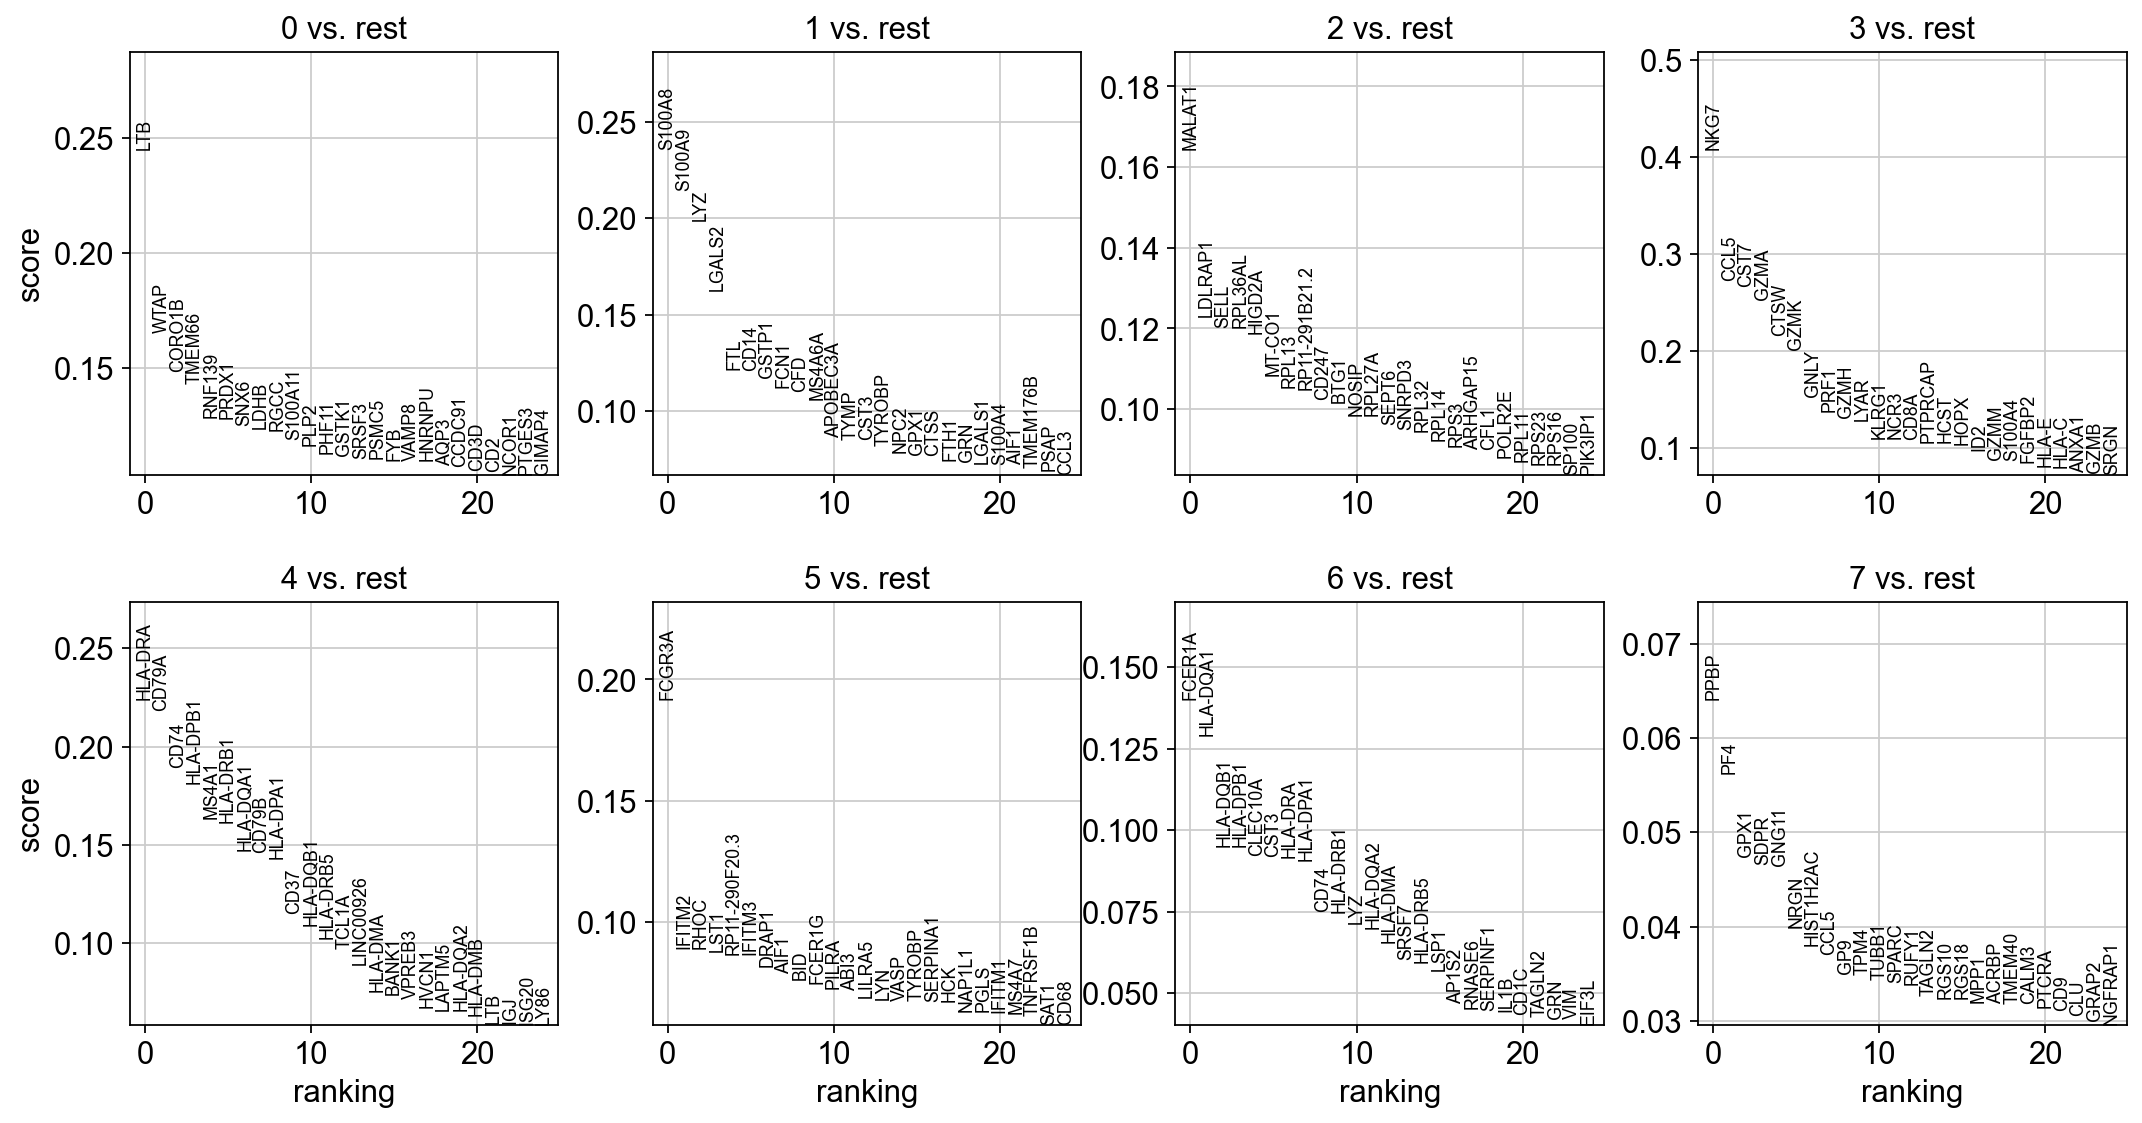

In [91]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [92]:
adata = sc.read(results_file)

In [93]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7
0,LDHB,LYZ,RPS12,NKG7,CD74,LST1,HLA-DPA1,PF4
1,LTB,S100A9,RPL32,CST7,CD79A,FCER1G,HLA-DPB1,SDPR
2,CD3D,S100A8,RPS27,GZMA,HLA-DRA,FCGR3A,HLA-DRA,GNG11
3,RPS12,TYROBP,RPL13,CTSW,CD79B,AIF1,HLA-DRB1,PPBP
4,IL32,FTL,RPS14,B2M,HLA-DPB1,COTL1,CD74,NRGN


In [94]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

Get a table with the scores and groups.

In [95]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,LDHB,9.989159e-129,LYZ,1.041696e-252,RPS12,2.139451e-78,NKG7,3.237641e-218,CD74,1.235199e-182,LST1,9.185927e-83,HLA-DPA1,5.422417e-21,PF4,4.722886e-10
1,LTB,1.682106e-109,S100A9,5.141960e-252,RPL32,3.747235e-76,CST7,6.368539e-171,CD79A,1.835522e-170,FCER1G,1.487539e-79,HLA-DPB1,7.591860e-21,SDPR,4.733899e-10
2,CD3D,8.307550e-101,S100A8,1.512596e-236,RPS27,1.878202e-72,GZMA,1.928633e-165,HLA-DRA,3.384552e-166,FCGR3A,3.162767e-79,HLA-DRA,1.306768e-19,GNG11,4.733899e-10
3,RPS12,2.943002e-89,TYROBP,1.677932e-226,RPL13,2.950533e-71,CTSW,2.066824e-159,CD79B,5.432254e-153,AIF1,1.405307e-77,HLA-DRB1,1.865104e-19,PPBP,4.744938e-10
4,IL32,1.530853e-87,FTL,6.823210e-225,RPS14,1.576044e-69,B2M,1.360019e-156,HLA-DPB1,1.079502e-147,COTL1,2.461962e-76,CD74,5.853161e-19,NRGN,4.800511e-10


compare to single cluster.

ranking genes
    finished (0:00:02)


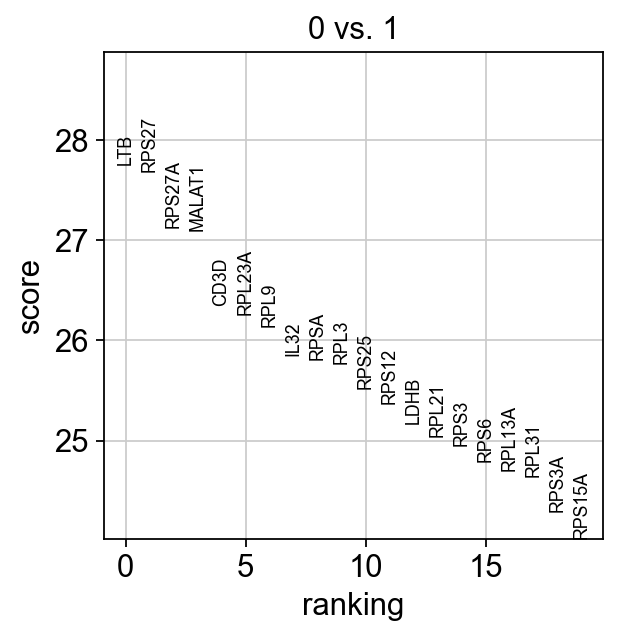

In [99]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

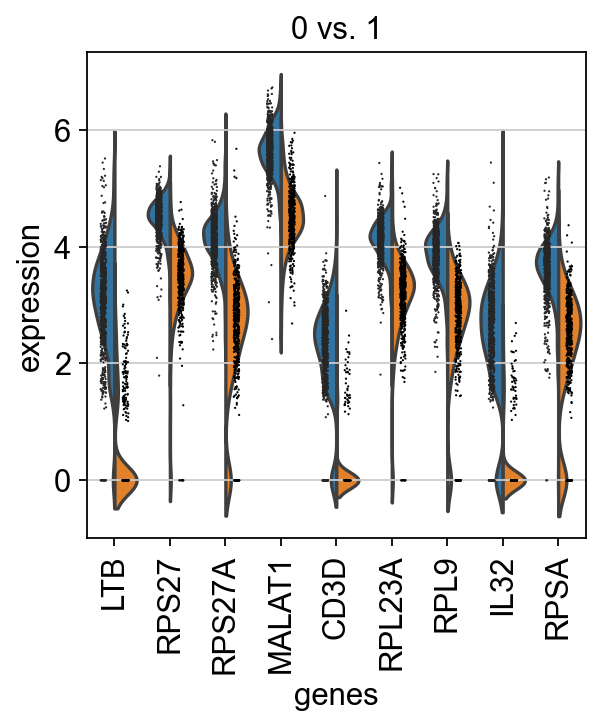

In [100]:
# more deltial about specific group for instance:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=9)

In [101]:
# reload computed differential expression
adata = sc.read(results_file)


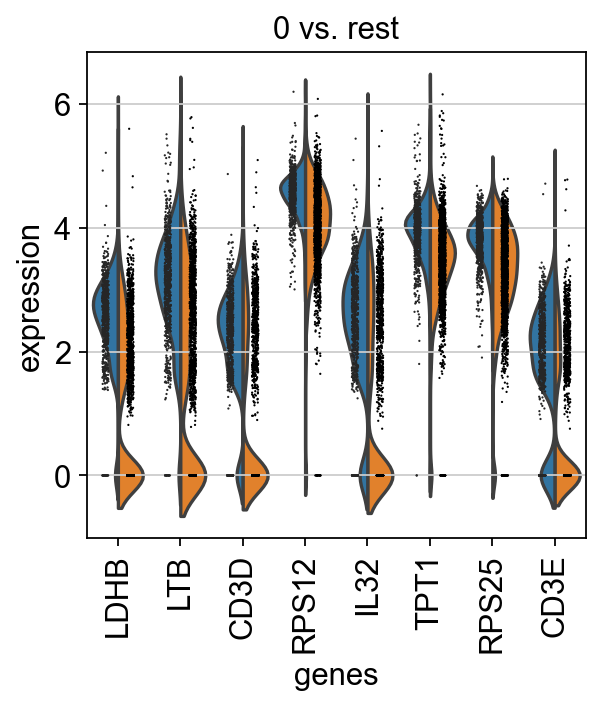

In [102]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)


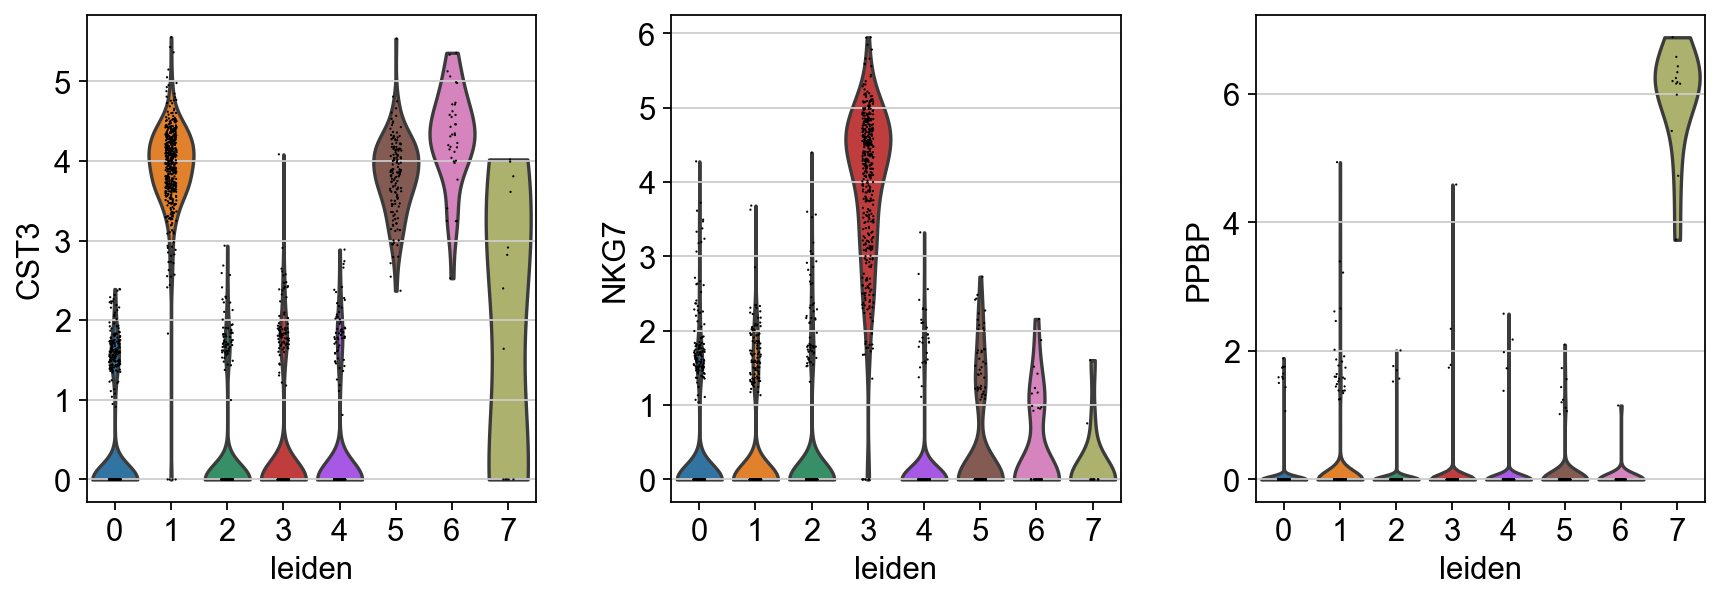

In [103]:
# compare certain gene across groups
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

mark the cell types.

In [104]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\anndata\_core\anndata.py:1160: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  self.obs[key].cat.rename_categories(categories, inplace=True)


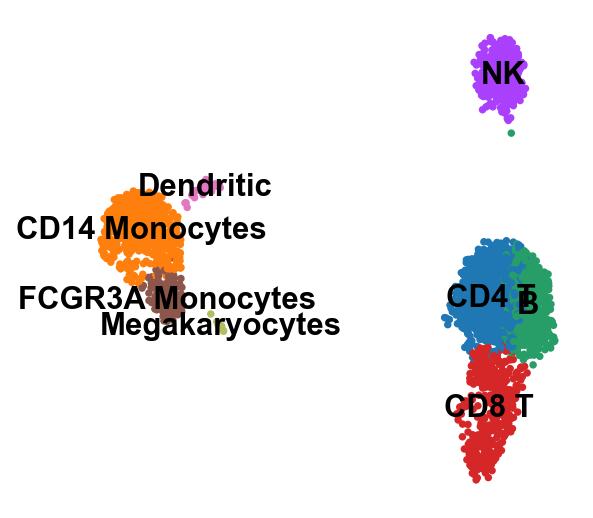

In [105]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')


In [115]:
adata




AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

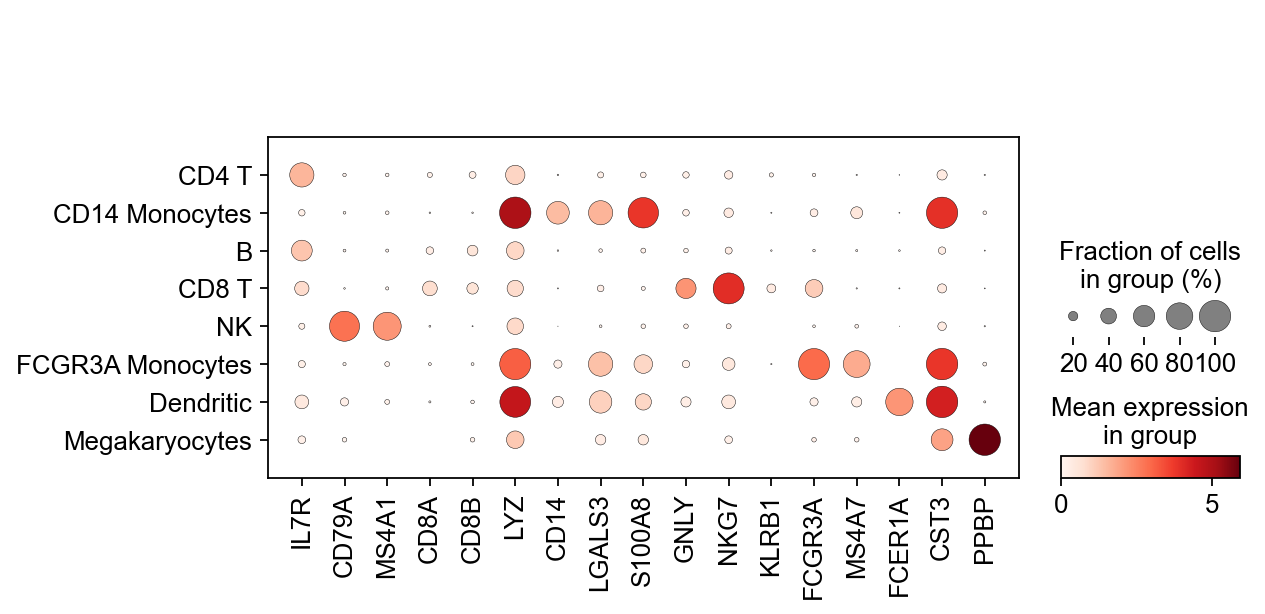

In [116]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');


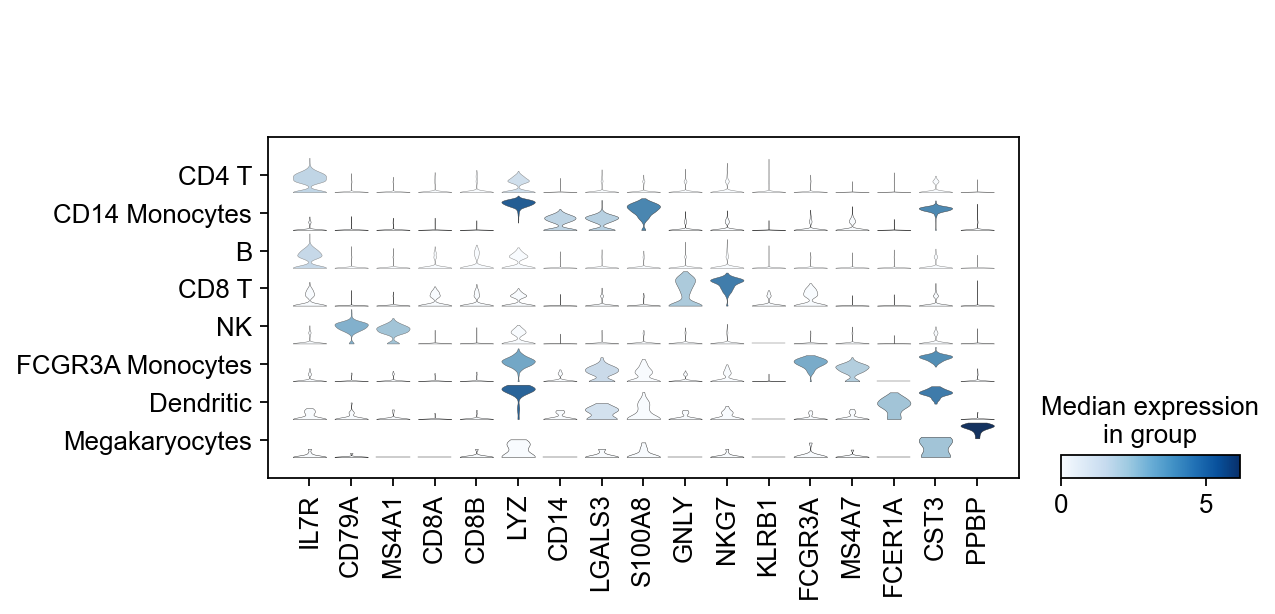

In [117]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);


In [118]:
adata


AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [119]:
adata.write(results_file, compression='gzip')